## SAT SCORE DISTRIBUTION BY U.S. STATE

CollegeBoard, authors of the SAT and AP exams, provides yearly reports by state in regards to how students performed on those tests. Here, we'll look at SAT scores by state and try to determine if some states outperform others. We'll use pandas, folium, and matplotlib.

In [23]:
import pandas as pd
import geopandas as gpd
import folium 
from folium import plugins
from folium.plugins import StripePattern
import numpy as np


We'll need folium's shape files to supply mappable state locations:

In [38]:
state_geo = ("https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json")
geoJSON_df = gpd.read_file(state_geo)
geoJSON_df.head()

,id,name,geometry
0,AL,Alabama,"POLYGON ((-87.35930 35.00118, -85.60667 34.984..."
1,AK,Alaska,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691..."
2,AZ,Arizona,"POLYGON ((-109.04250 37.00026, -109.04798 31.3..."
3,AR,Arkansas,"POLYGON ((-94.47384 36.50186, -90.15254 36.496..."
4,CA,California,"POLYGON ((-123.23326 42.00619, -122.37885 42.0..."


Now we'll merge the shapes with some columns of SAT data to get everything into one dataframe:

In [20]:
geoJSON_df=geoJSON_df.rename(columns = {"id":"stateabbr"})
state_scores = "https://raw.githubusercontent.com/NickKrausStack/SATdata/main/States.csv"
df = pd.read_csv(state_scores)
df = df[["stateabbr","TotalMean","Participation", "AP"]]
final_df = geoJSON_df.merge(df, on = "stateabbr")
final_df.head()

,stateabbr,name,geometry,TotalMean,Participation,AP
0,AL,Alabama,"POLYGON ((-87.35930 35.00118, -85.60667 34.984...",1146,0.04,13.5
1,AK,Alaska,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691...",1110,0.26,11.9
2,AZ,Arizona,"POLYGON ((-109.04250 37.00026, -109.04798 31.3...",1159,0.14,14.7
3,AR,Arkansas,"POLYGON ((-94.47384 36.50186, -90.15254 36.496...",1191,0.02,18.0
4,CA,California,"POLYGON ((-123.23326 42.00619, -122.37885 42.0...",1115,0.21,26.7


And now we are ready to leverage folium to produce a choropleth graph, which will provide an interactive account of averages by state.

In [48]:
m = folium.Map(location=[50, -102], zoom_start=2.5, tiles="stamen toner")

folium.Choropleth(
    geo_data=final_df,
    data=final_df,
    columns=["stateabbr", "TotalMean"],
    key_on="feature.properties.stateabbr",
    fill_color="GnBu",
    fill_opacity=0.9,
    line_opacity=0.2,
    legend_name="SAT Scores",
).add_to(m)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    data = final_df,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name','TotalMean'],
        aliases=['name','TotalMean'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(NIL)
m.keep_in_front(NIL)

m

There appears to be a cluster of states in the midwest that outperform all the other states - Montana, Wyoming, North Dakota, South Dakota, Nebraska, Kansas, Utah, Minnesota, Wisconsin, Missouri, Kentucky, Tennessee, and Mississippi. The difference is considerable. How can we explain these contradictory indicators of academic achievement?  Are these states home to an outsized proportion of geniuses?

I suspect that the average SAT score by state is a classic case of bad statistics. There is a significant external factor here that makes state-to-state comparisons a faulty venture: each state has different rates of participation. In other words, in some states as few as 5% of 12th graders took the exam, whereas in others over 90% took it. This matters a lot. We can easily draw up a matplotlib line chart to demonstrate the correlation between high proportion of test-takers and low average:

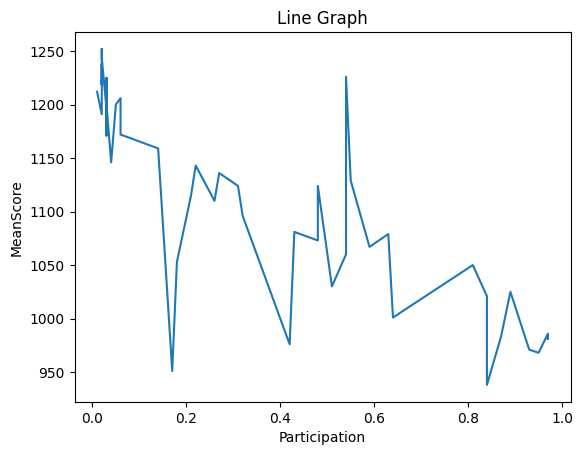

In [46]:
import matplotlib.pyplot as plt
df.head()
plt.plot(df['Participation'], df['TotalMean'])
plt.xlabel('Participation')
plt.ylabel('MeanScore')
plt.title('Line Graph')
plt.show()

 negative correlation between participation and average score is intuitive. If a very low percentage of the students take the exam, it is probably because students are not compelled or encourage to take it in the first place, and only the most academically driven students will take it on their own volition. In New York, for instance, where 97% of students take it, there is no such selection process. Students representing the whole range of academic performance take it, regardless of their interest or capability. This drives the statewide average down. 

In the case of the midwest cluster states, let's compare their participation rates to those of the rest of the country:

In [45]:
midweststates = ['Montana', 'Wyoming', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Utah', 'Minnesota', 'Wisconsin', 'Missouri', 'Kentucky', 'Tennessee', 'Mississippi']
midwestdf = final_df[final_df['name'].isin(midweststates)]
nomidwestdf = final_df[~final_df['name'].isin(midwest)]
print('avg participation, midwest: ', midwestdf['Participation'].mean())
print('avg participation, non midwest: ', nomidwestdf['Participation'].mean())

avg participation, midwest:  0.06615384615384617
avg participation, non midwest:  0.4848648648648649


The midwest cluster had a particpation rate of 6.6%. All other states averaged to 48%. This is a pretty staggering participation rate difference, and it accounts for why the midwest cluster states had a much higher average SAT scores.

To drive the point home, we can use data from the AP scores to show that, actually the midwest is not on average academically advanced. Here is a choropleth graph for the proportion of graduates in each state who passed at least one AP exam:

In [49]:
m = folium.Map(location=[50, -102], zoom_start=2.5, tiles="stamen toner")

folium.Choropleth(
    geo_data=final_df,
    data=final_df,
    columns=["stateabbr", "AP"],
    key_on="feature.properties.stateabbr",
    fill_color="GnBu",
    fill_opacity=0.9,
    line_opacity=0.2,
    legend_name="SAT Scores",
).add_to(m)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    data = final_df,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name','AP'],
        aliases=['name','AP'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(NIL)
m.keep_in_front(NIL)

m

We see the inverse of the first map we drew. The states in the midwest were particularly poor performers in this metric. This further demonstrates that the high SAT scores is probably the result of an external factor -- participation rates -- as we've laid out.